<a href="https://colab.research.google.com/github/beom2pm/KTds_edu_springBoot/blob/main/%EC%97%B4%EC%B2%98%EB%A6%AC_spc_%EB%B3%80%EC%88%98%EC%83%81%EA%B4%80%EA%B4%80%EA%B3%843.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 열처리 spc2 (선제적 이상탐지)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler

In [ ]:
# 데이터 로드
raw_df = pd.read_csv('raw_total_data.csv', parse_dates=['TAG_MIN'])
label_df = pd.read_excel('label.xlsx')

# 불필요한 빈 컬럼 제거 (모두 NaN 컬럼)
raw_df = raw_df.dropna(axis=1, how='all')

# 배정번호 타입 맞추기
raw_df['배정번호'] = raw_df['배정번호'].astype(str)
label_df['배정번호'] = label_df['배정번호'].astype(str)

# 불량률 계산
label_df['불량률'] = label_df['불량수량'] / label_df['총수량']

# 시간순 정렬
raw_df = raw_df.sort_values('TAG_MIN')

In [ ]:
# 센서 변수 리스트 (예: 주요 온도 및 출력량 컬럼만 추출)
sensor_cols = [
    '건조 1존 OP', '건조 2존 OP', '건조로 온도 1 Zone', '건조로 온도 2 Zone',
    '세정기',
    '소입1존 OP', '소입2존 OP', '소입3존 OP', '소입4존 OP',
    '소입로 CP 값',
    '소입로 온도 1 Zone', '소입로 온도 2 Zone', '소입로 온도 3 Zone', '소입로 온도 4 Zone',
    '솔트 컨베이어 온도 1 Zone', '솔트 컨베이어 온도 2 Zone',
    '솔트조 온도 1 Zone', '솔트조 온도 2 Zone'
]

# 결측치 처리 - 간단히 선형보간 (시계열 특성 고려)
raw_df[sensor_cols] = raw_df[sensor_cols].interpolate(method='linear')

# 각 배정번호별 그룹으로 묶고 시간순 정렬
grouped = raw_df.groupby('배정번호')

#SPC 관리도 지표 계산 함수 정의

** 서브그룹 단위로 나누는 이유는 공정 변동 특성을 더 잘 반영하기 위함입니다.

- 서브그룹 평균 (X̄, subgroup means)
  : 각 서브그룹 내 데이터들의 평균값을 구해서 공정의 중심 경향성을 확인
- 서브그룹 범위 (R, subgroup ranges)
: 서브그룹 내 데이터 최대값과 최소값 차이(범위)를 구해 공정 변동성(산포)을 측정합니다.

In [ ]:
def compute_spc_params(data, subgroup_size=5):
    """
    SPC X-bar 차트용 통계량 계산
    data: 1차원 배열(센서 값 시계열)
    subgroup_size: 서브그룹 크기 (ex: 5)
    """
    # 서브그룹으로 나누기
    subgroups = [data[i:i+subgroup_size] for i in range(0, len(data), subgroup_size) if len(data[i:i+subgroup_size]) == subgroup_size]

    subgroup_means = [np.mean(group) for group in subgroups]
    subgroup_ranges = [np.ptp(group) for group in subgroups]  # ptp: max-min

    Xbar_bar = np.mean(subgroup_means)
    R_bar = np.mean(subgroup_ranges)

    # d2 계수: subgroup_size별 표준값 참고
    d2_table = {2: 1.128, 3: 1.693, 4: 2.059, 5: 2.326, 6: 2.534}
    d2 = d2_table.get(subgroup_size, 2.326)  # 기본 5 적용

    sigma = R_bar / d2
    UCL = Xbar_bar + 3 * sigma
    LCL = Xbar_bar - 3 * sigma

    return subgroup_means, Xbar_bar, UCL, LCL

#변수별 SPC 차트 그리기 및 이상점 탐지 예시 (배정번호 단위 시간순)

In [22]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
from matplotlib.font_manager import FontProperties

# ✅ 시스템에 설치된 한글 폰트 경로 찾기 (예: NanumGothic)
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # Colab에서 주로 사용
font_prop = FontProperties(fname=font_path)

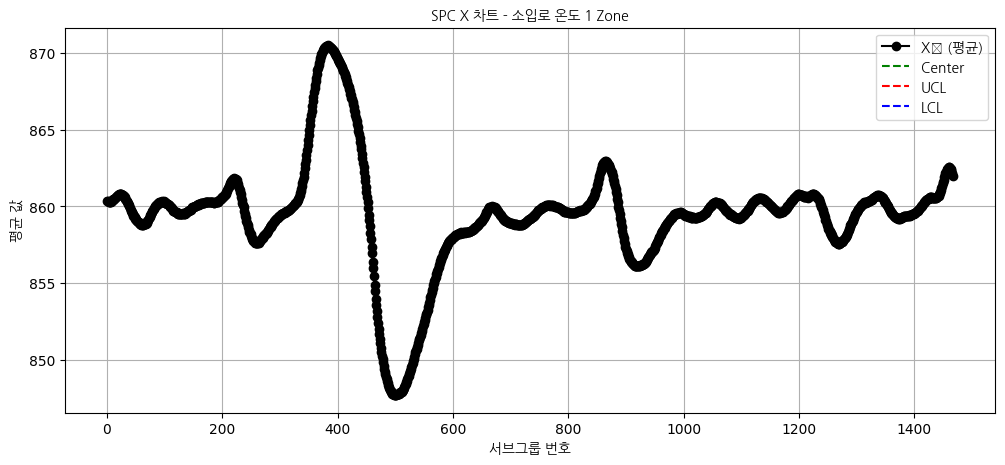

In [ ]:
def plot_spc(sensor_data, sensor_name, subgroup_size=5):
    means, center, UCL, LCL = compute_spc_params(sensor_data, subgroup_size)

    plt.figure(figsize=(12, 5))
    plt.plot(means, marker='o', label='X (평균)', color='black')
    plt.axhline(center, color='green', linestyle='--', label='Center')
    plt.axhline(UCL, color='red', linestyle='--', label='UCL')
    plt.axhline(LCL, color='blue', linestyle='--', label='LCL')

    plt.title(f'SPC X 차트 - {sensor_name}', fontsize=15, fontproperties=font_prop)
    plt.xlabel('서브그룹 번호', fontproperties=font_prop)
    plt.ylabel('평균 값', fontproperties=font_prop)
    plt.legend(prop=font_prop)
    plt.grid(True)
    plt.show()

# 예: 특정 배정번호의 소입로 온도 1 Zone SPC 그리기
sample_batch = '102410'
sensor_col = '소입로 온도 1 Zone'

batch_data = raw_df[raw_df['배정번호'] == sample_batch].sort_values('TAG_MIN')[sensor_col].values
plot_spc(batch_data, sensor_col, subgroup_size=5)

multiple로 시도

In [ ]:
def plot_multiple_spc(df, sensor_cols, batch_col='배정번호', batch_id='102410', subgroup_size=5):
    batch_data = df[df[batch_col] == batch_id].sort_values('TAG_MIN')

    for sensor_col in sensor_cols:
        sensor_data = batch_data[sensor_col].dropna().values  # 결측치 제거
        if len(sensor_data) < subgroup_size * 2:
            print(f"⚠️ {sensor_col}은 데이터가 부족하여 생략합니다.")
            continue

        means, center, UCL, LCL = compute_spc_params(sensor_data, subgroup_size)

        plt.figure(figsize=(12, 4))
        plt.plot(means, marker='o', label='X (평균)', color='black')
        plt.axhline(center, color='green', linestyle='--', label='Center')
        plt.axhline(UCL, color='red', linestyle='--', label='UCL')
        plt.axhline(LCL, color='blue', linestyle='--', label='LCL')

         # ✅ 한글 폰트 적용
        plt.title(f'SPC X 차트 - {sensor_col} (배정번호: {batch_id})',
                  fontproperties=font_prop, fontsize=14)
        plt.xlabel('서브그룹 번호', fontproperties=font_prop)
        plt.ylabel('평균 값', fontproperties=font_prop)
        plt.legend(prop=font_prop)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

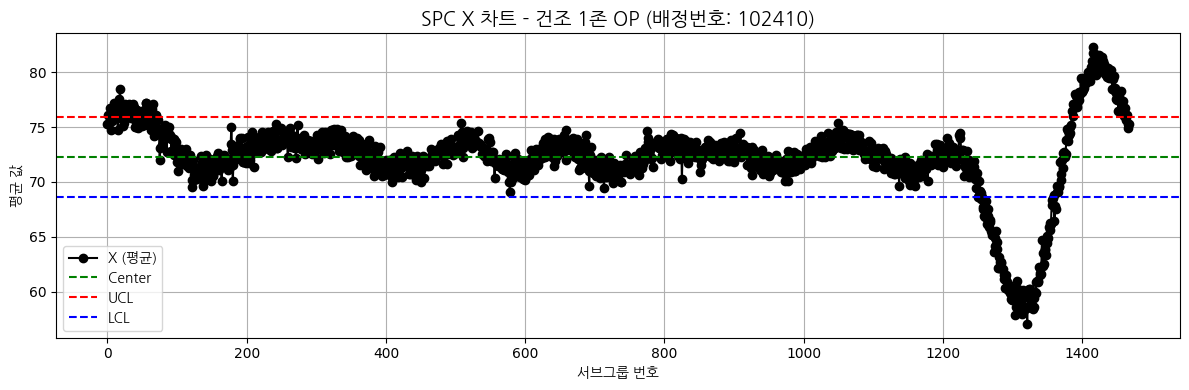

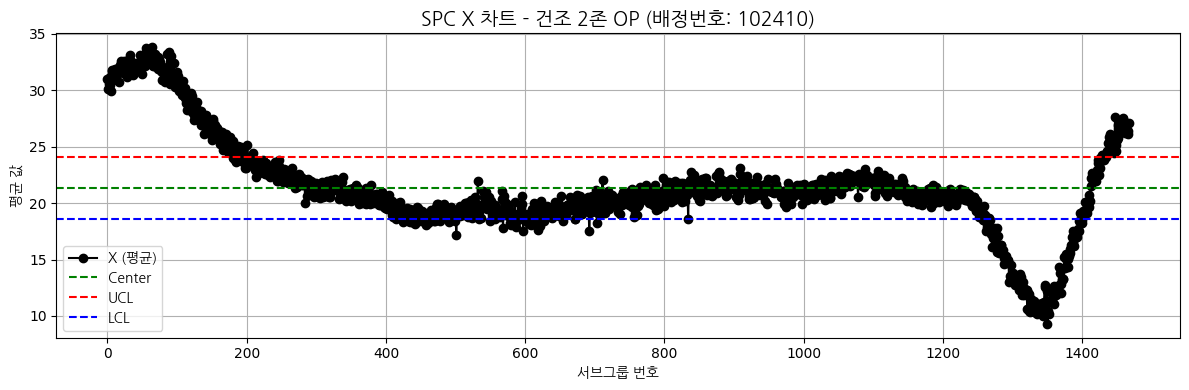

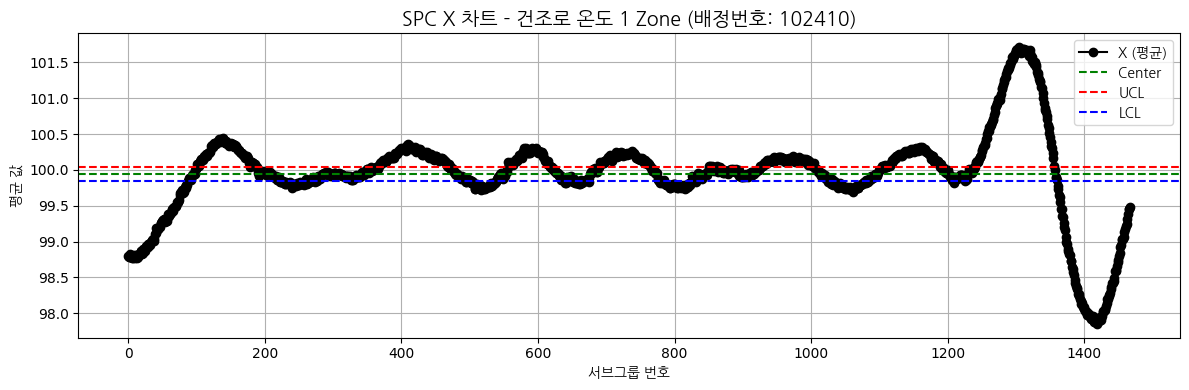

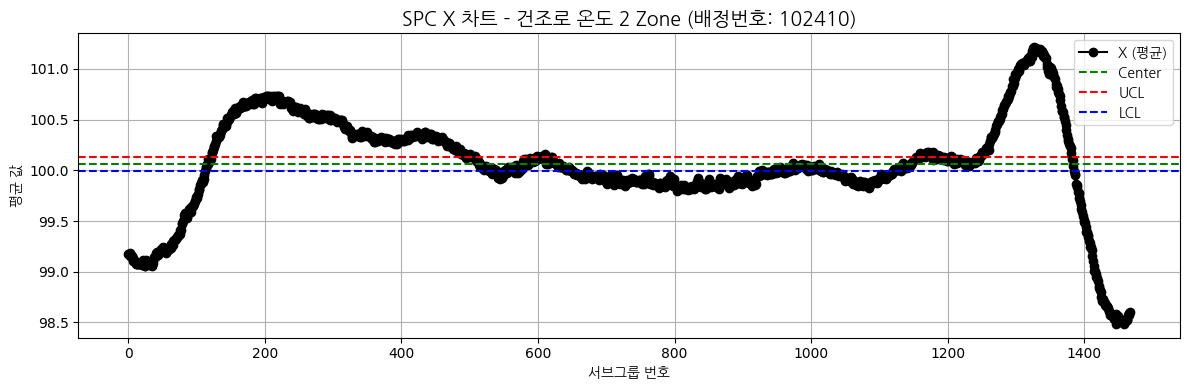

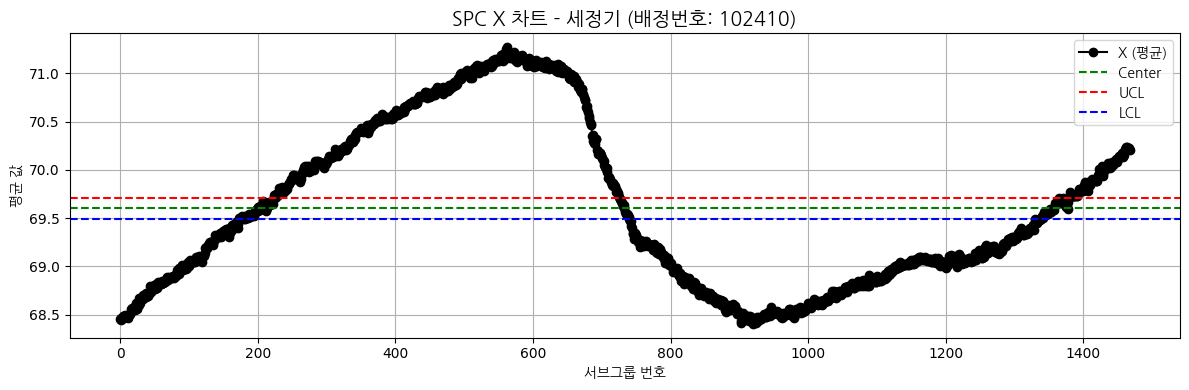

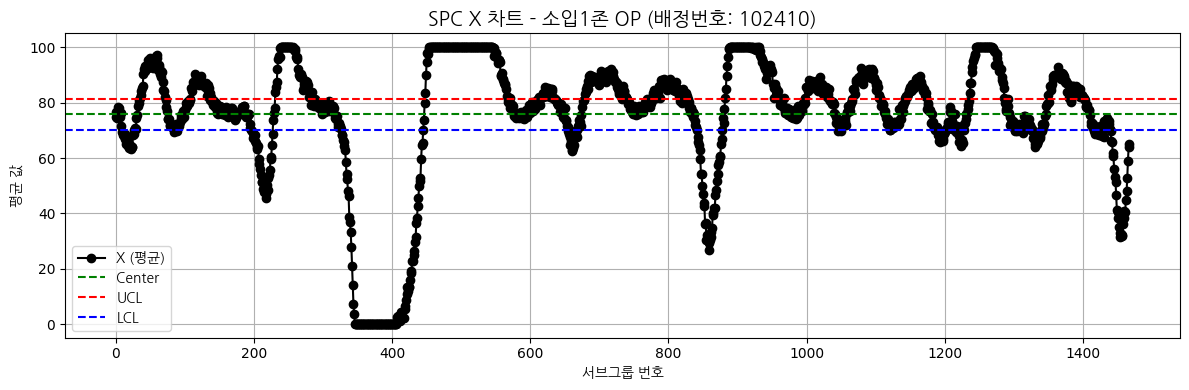

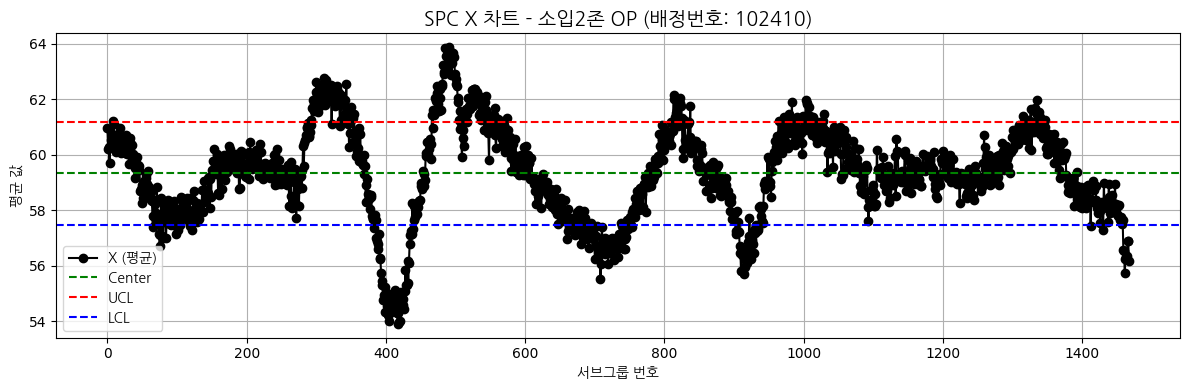

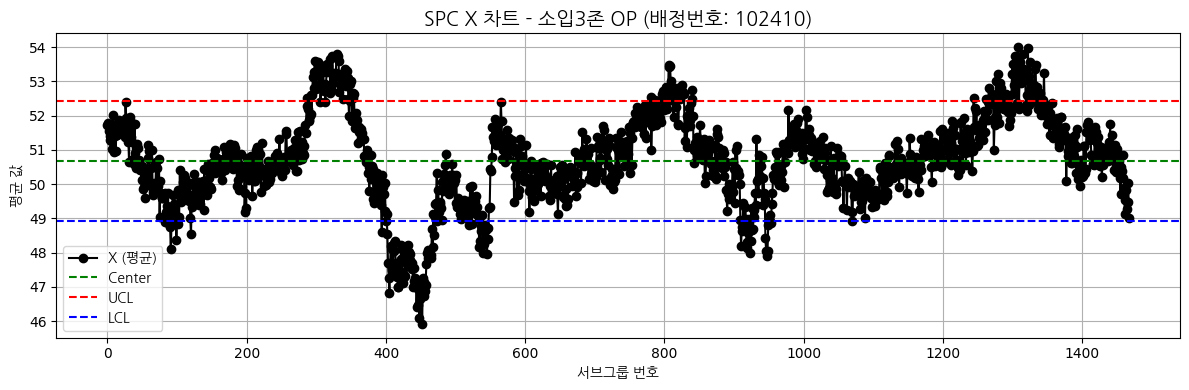

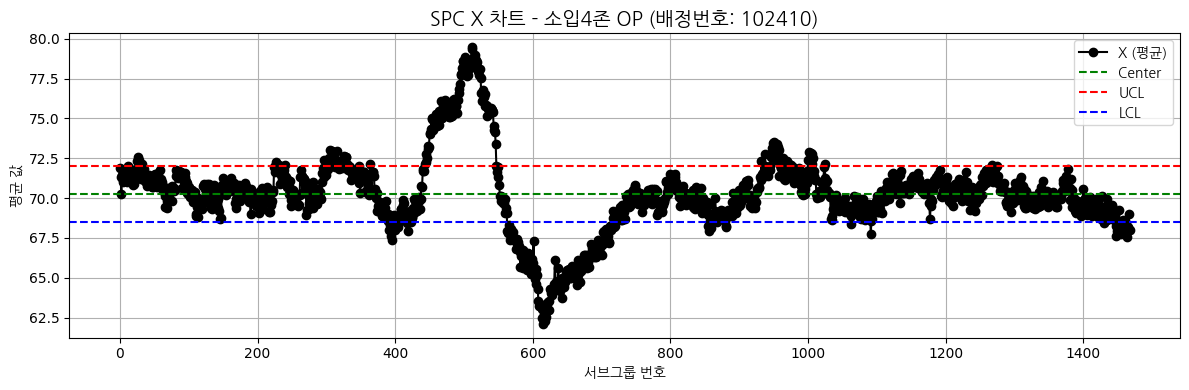

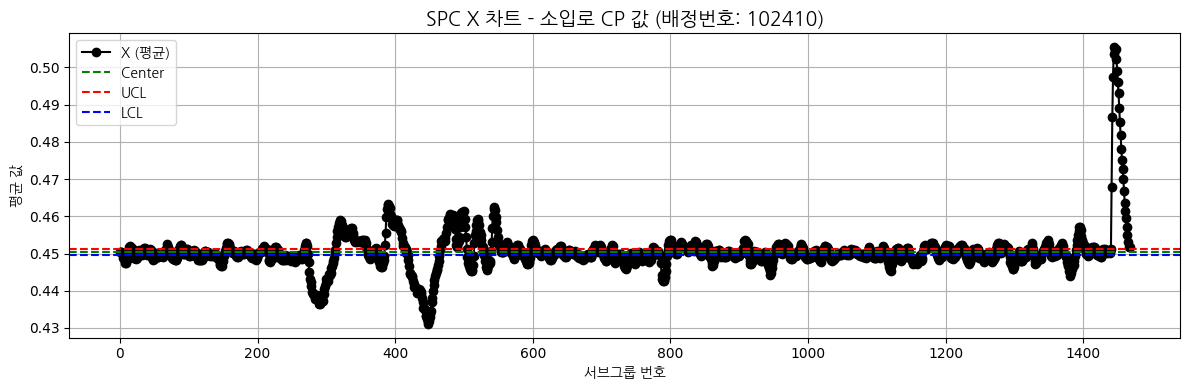

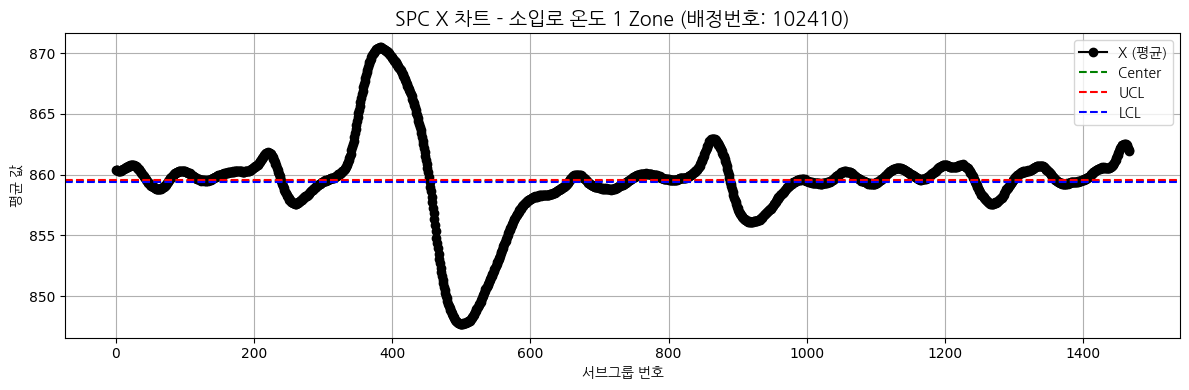

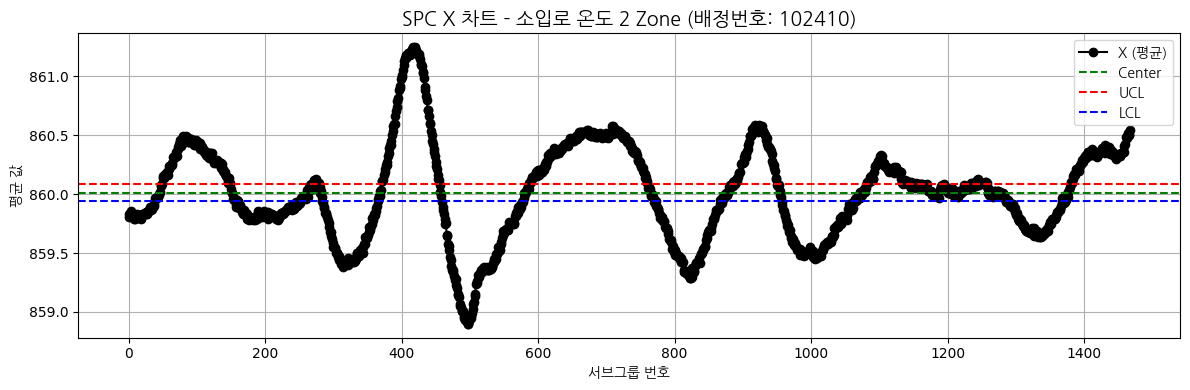

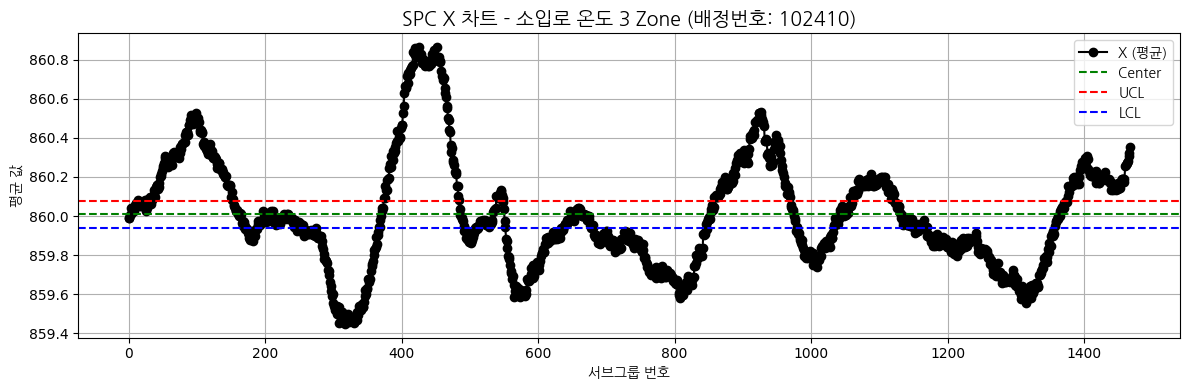

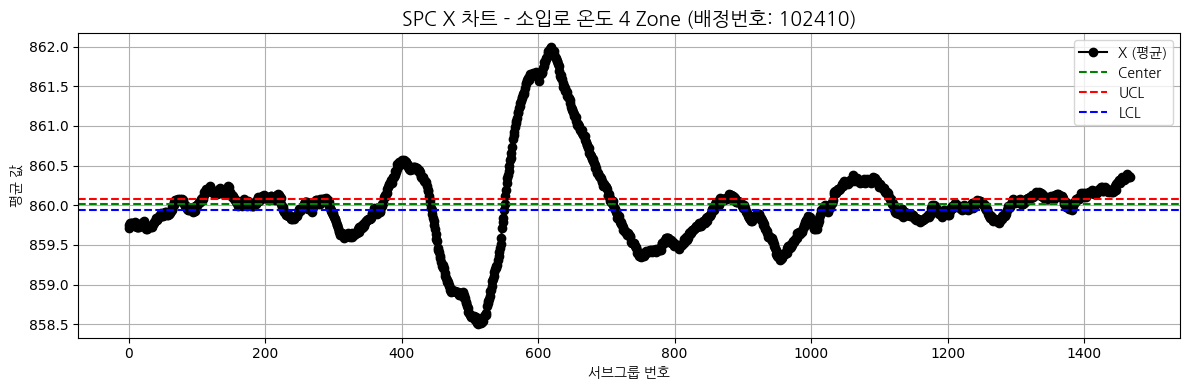

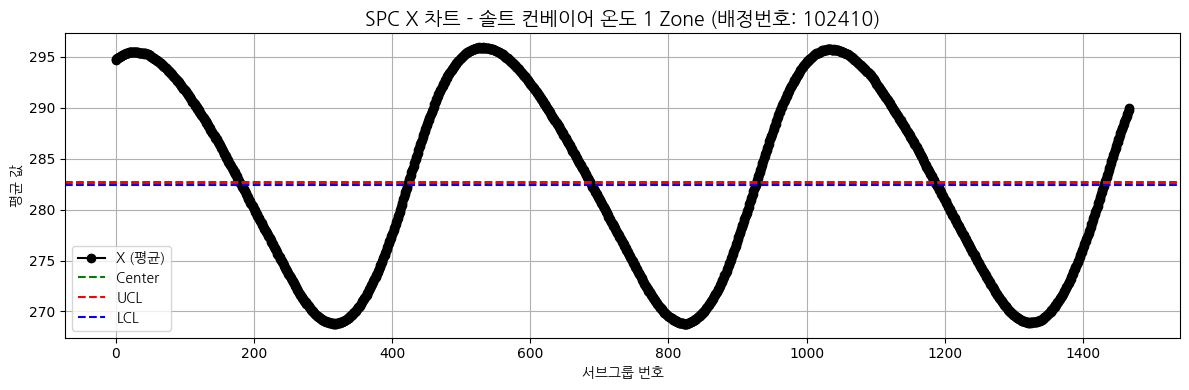

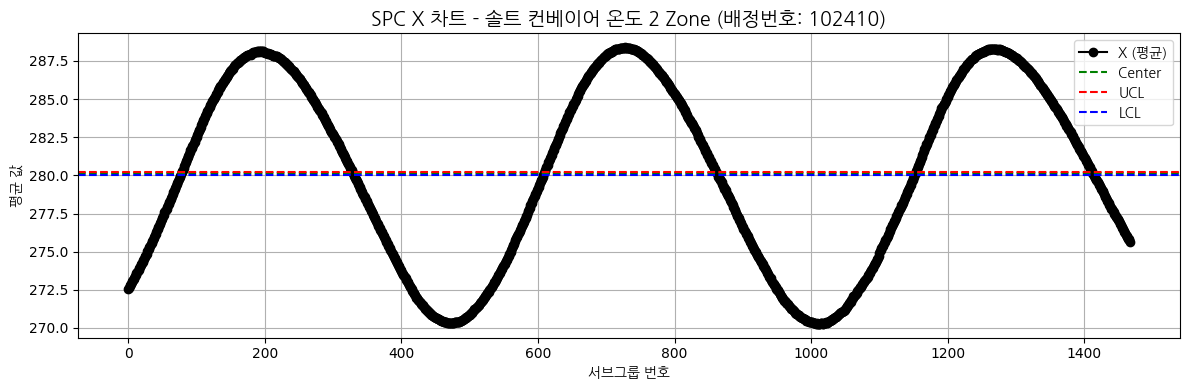

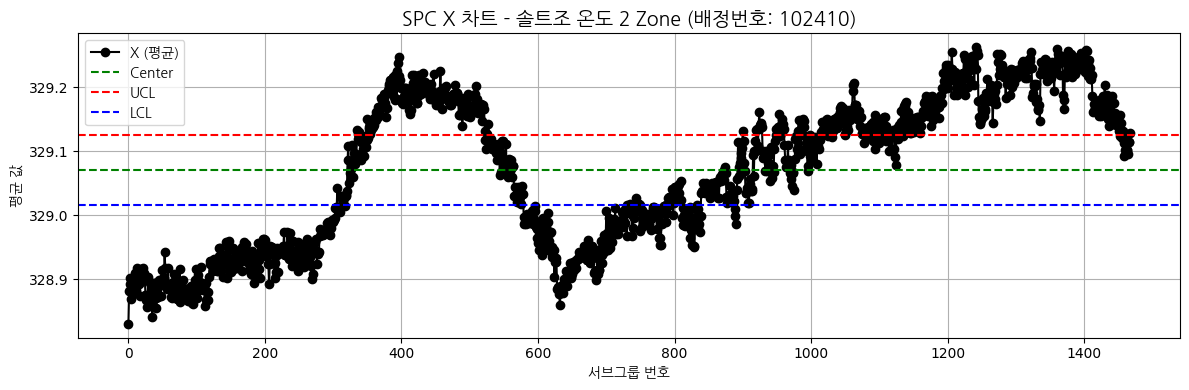

In [ ]:
sensor_columns = [
    '건조 1존 OP', '건조 2존 OP', '건조로 온도 1 Zone', '건조로 온도 2 Zone',
    '세정기', '소입1존 OP', '소입2존 OP', '소입3존 OP', '소입4존 OP',
    '소입로 CP 값', '소입로 온도 1 Zone', '소입로 온도 2 Zone',
    '소입로 온도 3 Zone', '소입로 온도 4 Zone',
    '솔트 컨베이어 온도 1 Zone', '솔트 컨베이어 온도 2 Zone',
    '솔트조 온도 2 Zone'
]

plot_multiple_spc(raw_df, sensor_columns, batch_id='102410', subgroup_size=5)

#이상점 감지 및 불량률 연계 (배정번호 기준)


In [ ]:
def detect_spc_out_of_control(means, UCL, LCL):
    """ SPC 관리 한계선 위반(이상점) 인덱스 반환 """
    out_of_control_idx = [i for i, val in enumerate(means) if val > UCL or val < LCL]
    return out_of_control_idx

# 여러 배정번호 전체에 대해 이상점과 불량률 연계 예시
results = []

for batch_no, group in raw_df.groupby('배정번호'):
    for sensor_col in sensor_cols:
        sensor_vals = group.sort_values('TAG_MIN')[sensor_col].values
        if len(sensor_vals) < 10:  # 데이터 적으면 스킵
            continue
        means, center, UCL, LCL = compute_spc_params(sensor_vals, subgroup_size=5)
        out_idx = detect_spc_out_of_control(means, UCL, LCL)
        if out_idx:
            # label 불량률 가져오기
            defect_rate = label_df[label_df['배정번호'] == batch_no]['불량률'].values
            defect_rate = defect_rate[0] if len(defect_rate) > 0 else np.nan
            results.append({'배정번호': batch_no, '센서': sensor_col, '이상점_개수': len(out_idx), '불량률': defect_rate})

spc_anomalies_df = pd.DataFrame(results)
print(spc_anomalies_df.head())

     배정번호        센서  이상점_개수       불량률
0  102410  건조 1존 OP     226  0.000198
1  102410  건조 2존 OP     415  0.000198
2  102410       세정기    1366  0.000198
3  102410   소입1존 OP     976  0.000198
4  102410   소입2존 OP     367  0.000198


#SPC 기반 선제 경고 시스템: 공정 변수의 이상 탐지를 통해 불량 발생 예측


In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 데이터 불러오기
raw_df = pd.read_csv("raw_total_data.csv")
label_df = pd.read_excel("label.xlsx")

# 병합
df_total = pd.merge(raw_df, label_df, on='배정번호', how='left')
sensor_cols = [col for col in raw_df.columns if col not in ['배정번호', 'TAG_MIN']]

테스트 분리

In [12]:
# 불량률 계산
label_df['불량률'] = label_df.apply(
    lambda row: row['불량수량'] / row['총수량'] if row['총수량'] > 0 else np.nan,
    axis=1
)

# 불량률 기준으로 분리 (불량률이 낮은 걸 train으로)
threshold = 0.01
normal_batches = label_df[label_df['불량률'] <= threshold]['배정번호'].unique()
abnormal_batches = label_df[label_df['불량률'] > threshold]['배정번호'].unique()

train_batches, test_batches = train_test_split(normal_batches, test_size=0.3, random_state=42)

train_df = df_total[df_total['배정번호'].isin(train_batches)]
test_df = df_total[df_total['배정번호'].isin(test_batches)]

In [18]:
train_df


,TAG_MIN,배정번호,건조 1존 OP,건조 2존 OP,건조로 온도 1 Zone,건조로 온도 2 Zone,세정기,소입1존 OP,소입2존 OP,소입3존 OP,...,원소재,변형(폭),내폭,외폭,형상파손,경도,인장경도,초도품,TEST,경도측정
7342,2022-01-03 22:35:20,102585,70.7139,24.280000,100.1760,100.604,70.4182,NaN,57.7262,48.2296,...,0,0,10,0,0,0,0,0,0,0
7343,2022-01-03 22:35:21,102585,70.6176,24.357100,100.1760,100.604,70.4182,NaN,57.7966,48.2860,...,0,0,10,0,0,0,0,0,0,0
7344,2022-01-03 22:35:22,102585,70.5329,24.301600,100.1760,100.543,70.3569,NaN,57.8607,48.3371,...,0,0,10,0,0,0,0,0,0,0
7345,2022-01-03 22:35:23,102585,72.7178,24.374200,100.1760,100.604,70.4182,NaN,57.9637,48.4758,...,0,0,10,0,0,0,0,0,0,0
7346,2022-01-03 22:35:24,102585,70.1562,24.436900,100.1140,100.604,70.3569,NaN,59.5346,50.0307,...,0,0,10,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2939717,2022-07-19 19:08:55,148069,61.2937,0.093966,99.9056,100.487,67.1140,71.8356,60.7118,50.3777,...,0,0,0,0,0,0,0,0,0,0
2939718,2022-07-19 19:08:56,148069,61.7260,0.283887,99.8440,100.487,67.1140,77.1783,60.6722,55.0392,...,0,0,0,0,0,0,0,0,0,0
2939719,2022-07-19 19:08:57,148069,61.6784,0.205745,99.7825,100.487,67.1140,73.1729,62.1574,56.4989,...,0,0,0,0,0,0,0,0,0,0
2939720,2022-07-19 19:08:58,148069,61.5148,0.136414,99.8440,100.487,67.1140,73.8443,62.0722,54.8139,...,0,0,0,0,0,0,0,0,0,0


SPC에서는 보통 공정 데이터 그룹 내 평균 및 표준편차 기반으로 통제한계 계산

UCL(상한선), LCL(하한선)은 평균 ± (3 × 표준편차) 등으로 설정

본 데이터셋에서는 센서별 시계열 데이터를 subgroup(예: 5개) 단위 평균 시퀀스로 변환 후 통계치 계산

In [13]:
def compute_spc_params(data, subgroup_size=5):
    subgroups = [data[i:i+subgroup_size] for i in range(0, len(data), subgroup_size) if len(data[i:i+subgroup_size]) == subgroup_size]
    means = [np.mean(sg) for sg in subgroups]
    ranges = [np.max(sg) - np.min(sg) for sg in subgroups]

    mean_bar = np.mean(means)
    R_bar = np.mean(ranges)

    # X-bar 차트용 관리 한계선
    d2 = 2.326  # subgroup_size=5 기준
    UCL = mean_bar + 3 * R_bar / d2
    LCL = mean_bar - 3 * R_bar / d2

    return means, mean_bar, UCL, LCL

이상점 탐지
통제한계 밖에 위치하는 평균값을 이상점으로 판단

이상점이 많이 발생하는 배정번호가 불량률도 높다면, 해당 센서 변수가 품질에 영향이 있다고 볼 수 있음

In [14]:
def detect_spc_out_of_control(means, UCL, LCL):
    return [i for i, val in enumerate(means) if val > UCL or val < LCL]

train 데이터 기반 SPC 분석 및 기준 저장

In [15]:
spc_reference = {}

for col in sensor_cols:
    values = train_df[col].dropna().values
    if len(values) < 10:
        continue
    means, mean_bar, UCL, LCL = compute_spc_params(values)
    spc_reference[col] = {'UCL': UCL, 'LCL': LCL, 'Center': mean_bar}

test 데이터에서 이상점 감지 및 불량률 비교

In [16]:
results = []

for batch_id, group in test_df.groupby('배정번호'):
    for col in sensor_cols:
        values = group.sort_values('TAG_MIN')[col].dropna().values
        if len(values) < 10 or col not in spc_reference:
            continue

        means, *_ = compute_spc_params(values)
        ref = spc_reference[col]
        outliers = detect_spc_out_of_control(means, ref['UCL'], ref['LCL'])

        if outliers:
            defect_rate = label_df[label_df['배정번호'] == batch_id]['불량률'].values[0]
            results.append({
                '배정번호': batch_id,
                '센서': col,
                '이상점_개수': len(outliers),
                '불량률': defect_rate
            })

spc_anomaly_df = pd.DataFrame(results)
print(spc_anomaly_df.head())

     배정번호             센서  이상점_개수       불량률
0  102410       건조 1존 OP     567  0.000198
1  102410       건조 2존 OP     395  0.000198
2  102410  건조로 온도 1 Zone    1110  0.000198
3  102410  건조로 온도 2 Zone    1146  0.000198
4  102410            세정기    1468  0.000198


불량률이 일정 기준 이상이거나 SPC 이상점이 존재하는 배정번호-센서 조합만 선별해서,
이상점이 포함된 관리도(Control Chart)를 시각화 및 저장

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil

def compute_spc_params(values, subgroup_size=5):
    n = len(values)
    num_groups = n // subgroup_size
    means = [np.mean(values[i*subgroup_size:(i+1)*subgroup_size]) for i in range(num_groups)]
    center = np.mean(means)
    sigma = np.std(means, ddof=1)
    UCL = center + 3 * sigma
    LCL = center - 3 * sigma
    return means, center, UCL, LCL

def detect_spc_out_of_control(means, UCL, LCL):
    return [i for i, val in enumerate(means) if val > UCL or val < LCL]

def plot_control_chart(means, center, UCL, LCL, outliers, title, show=True, save_path=None):
    plt.figure(figsize=(10, 5))
    plt.plot(means, marker='o', label='서브그룹 평균', color='blue')
    plt.axhline(center, color='green', linestyle='--', label='중심선(CL)')
    plt.axhline(UCL, color='red', linestyle='--', label='상한선(UCL)')
    plt.axhline(LCL, color='red', linestyle='--', label='하한선(LCL)')

    if outliers:
        plt.scatter(outliers, [means[i] for i in outliers], color='red', label='이상점')

    plt.title(title, fontproperties=font_prop)
    plt.xlabel('서브그룹 인덱스', fontproperties=font_prop)
    plt.ylabel('센서 값', fontproperties=font_prop)
    plt.legend(prop=font_prop)
    plt.grid(True)
    plt.tight_layout()

    if show:
        plt.show()
    if save_path:
        plt.savefig(save_path)
        plt.close()

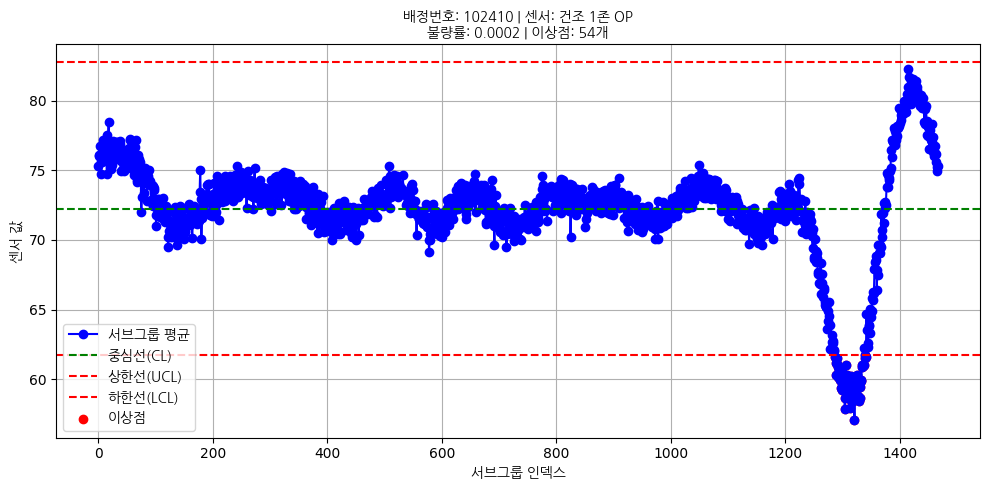

In [29]:
# 저장할 폴더 생성
# 2. 이전 결과 삭제 및 디렉토리 재생성
output_dir = 'spc_charts'
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.makedirs(output_dir)

threshold_defect_rate = 0.01  # 불량률 1% 이상이면 문제로 간주

shown = False  # 첫 번째만 화면 출력, 나머지는 저장

for batch_id, group in test_df.groupby('배정번호'):
    defect_row = label_df[label_df['배정번호'] == batch_id]
    if defect_row.empty:
        continue
    defect_rate = defect_row['불량률'].values[0]

    for col in sensor_cols:
        values = group.sort_values('TAG_MIN')[col].dropna().values
        if len(values) < 10:
            continue

        means, center, UCL, LCL = compute_spc_params(values)
        outliers = detect_spc_out_of_control(means, UCL, LCL)

        if defect_rate > threshold_defect_rate or outliers:
            title = f'배정번호: {batch_id} | 센서: {col}\n불량률: {defect_rate:.4f} | 이상점: {len(outliers)}개'

            if not shown:
                # 첫 번째 결과는 화면 출력
                plot_control_chart(means, center, UCL, LCL, outliers, title, show=True)
                shown = True
            else:
                # 나머지는 저장
                fname = f'{batch_id}_{col.replace(" ", "_")}.png'
                save_path = os.path.join(output_dir, fname)
                plot_control_chart(means, center, UCL, LCL, outliers, title, show=False, save_path=save_path)

센서 시계열 값을 서브그룹 평균으로 구간화하고,

중심선(CL) ± 3σ의 범위를 기준으로 SPC의 통제 한계선(UCL/LCL) 을 그림

이 중 벗어난 점을 이상점으로 보고,

불량률과의 상관성을 시각적으로 파악 → 선제 대응 근거